##### Copyright (c) 2021 Spanish National Research Council

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

This tutorial is based on the Tensorflow tutorial [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en#multi-step_models).

The aim of this notebook is to forecast COVID-19 time series using TensorFlow. The models are Convolutional and Recurrent Neural Networks (CNNs and RNNs). 

Concepts:
* **Univariate Time Series**: These are datasets where only a single variable is observed at each time, such as temperature each hour. The example in the previous section is a univariate time series dataset.
* **Multivariate Time Series**: These are datasets where two or more variables are observed at each time. 
* **One-Step Forecast**: This is where the next time step (t+1) is predicted.
* **Multi-Step Forecast**: This is where two or more future time steps are to be predicted.

## Index

[Forecast multiple steps](#i1):
  * [Single-shot](#i2): Make the predictions all at once.
    1. [Linear model](#linear)
    2. [Dense model](#dense)
    3. [Feed Forward Neural Network](#ffnn)
    4. [Convolutional Neural Network (CNN)](#CNN)
    5. [Recurrent Neural Network (RNN)](#RNN)
  * [Autoregressive](#i3): Make one prediction at a time and feed the output back to the model.
    1. [Recurrent Neural Network (RNN)](#RNN)

## Setup

In [2]:
import os
import sys
import pathlib
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, Lambda, Conv1D

from IPython.display import Image
from IPython.core.display import HTML 

mpl.rcParams['figure.figsize'] = (14, 9)
mpl.rcParams['axes.grid'] = False

sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))

## COVID-19 dataset

This project uses a covid-19 data from Cantabria (Spain) obtained from:

1. [Cantabria Health Service](https://www.scsalud.es/coronavirus).
2. [Cantabria Institute of Statistics](https://www.icane.es/covid19/dashboard/home/home) (ICANE).
3. [Ministry of Health, Consumer Affairs and Social Welfare](https://www.mscbs.gob.es).

To generate and process regional COVID-19 data from scratch use:
```bash
python src/data.py
python src/data.py --files covid
```
The dataset to be used is located in ./data/processed/covid/region/all_data_cantb.csv. This dataset contains 20 different features such as daily positive cases, daily deaths, hospital and ICU bed occupancy, daily pcr tests, 7-day and 14-day cumulative incidence and the number of people vaccinated. These were collected every day, beginning in 29 February 2020.


If you are running this notebook on Google Collab you must upload the file and execute the following code cell:

In [3]:
df = pd.read_csv('all_data_cantb.csv', sep=',')
df = df.set_index('date')

Otherwise, run the following cell:

In [ ]:
from utils import Paths
PATHS = Paths()
data_path = PATHS.processed / 'covid' / 'region' / 'all_data_cantb.csv'
df = pd.read_csv(data_path, sep=',').copy()
df = df.set_index('date')

In [5]:
df.head()

,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,cases7,cases14,incidence7,incidence14,new_hospital_cases,new_icu_cases,daily_positivity
date,,,,,,,,,,,,,,,,,,
2020/02/29,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
2020/03/01,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
2020/03/02,9,0,10,0,0,0,0,10,0,1,10,0,0,0,0,0,0,0.9
2020/03/03,0,0,10,0,0,0,0,24,0,1,24,0,0,0,0,0,0,0.0
2020/03/04,0,0,10,0,0,0,0,24,0,1,24,0,0,0,0,0,0,0.0


Here is the evolution of a few features over time:

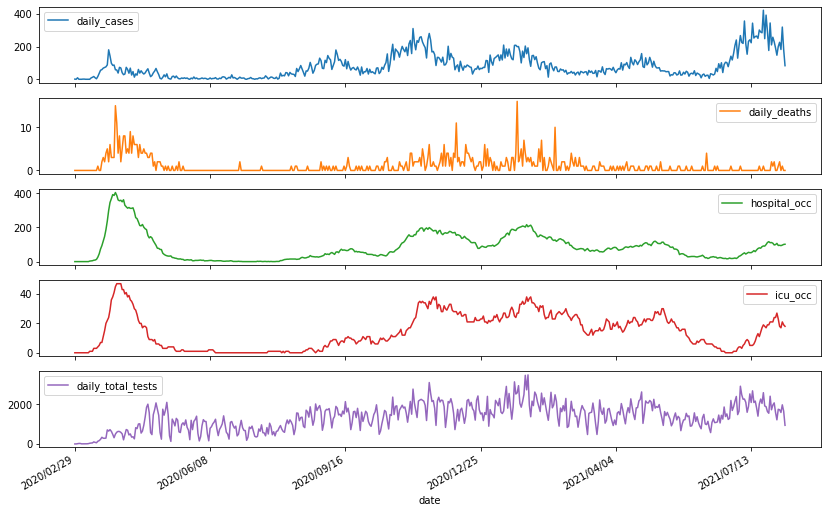

In [6]:
plot_cols = ['daily_cases', 'daily_deaths', 'hospital_occ', 'icu_occ', 'daily_total_tests']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

# plot_features = df[plot_cols][:120]
# plot_features.index = df.index[:120]
# _ = plot_features.plot(subplots=True)

## Inspect
Next, look at the statistics of the dataset. All variables must be positive and `date` column should be date type.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
daily_cases,526.0,80.760456,74.828920,0.0,26.250000,60.000000,114.750000,422.0
daily_deaths,526.0,1.123574,1.968789,0.0,0.000000,0.000000,1.000000,16.0
cumulative_cases,526.0,15846.741445,12587.817314,1.0,3108.750000,14881.000000,27161.500000,42404.0
cumulative_deaths,526.0,345.437262,178.013918,0.0,211.000000,291.500000,547.000000,589.0
icu_occ,526.0,14.256654,11.988117,0.0,2.000000,12.000000,23.750000,47.0
daily_antibody_tests,526.0,84.068441,163.308435,0.0,0.000000,38.500000,83.000000,1284.0
daily_antigen_tests,526.0,39.359316,47.013779,0.0,0.000000,0.000000,73.000000,245.0
daily_pcr_tests,526.0,1243.619772,637.336738,0.0,743.750000,1273.500000,1726.250000,3307.0
vaccinated_pp,526.0,30053.268061,74238.952101,0.0,0.000000,0.000000,0.000000,353807.0
hospital_occ,526.0,85.391635,78.953336,1.0,24.000000,70.000000,121.000000,403.0


The processing of the data has been done before when the dataset has been generated.

## Split the data
I will use a `(80%, 15%, 5%)` split for the training, validation, and test sets. The data is **not** being randomly shuffled before splitting because:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.95)]
test_df = df[int(n*0.95):]

num_features = df.shape[1]

## Normalize the data
Before training a neural network it is important to scale features. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

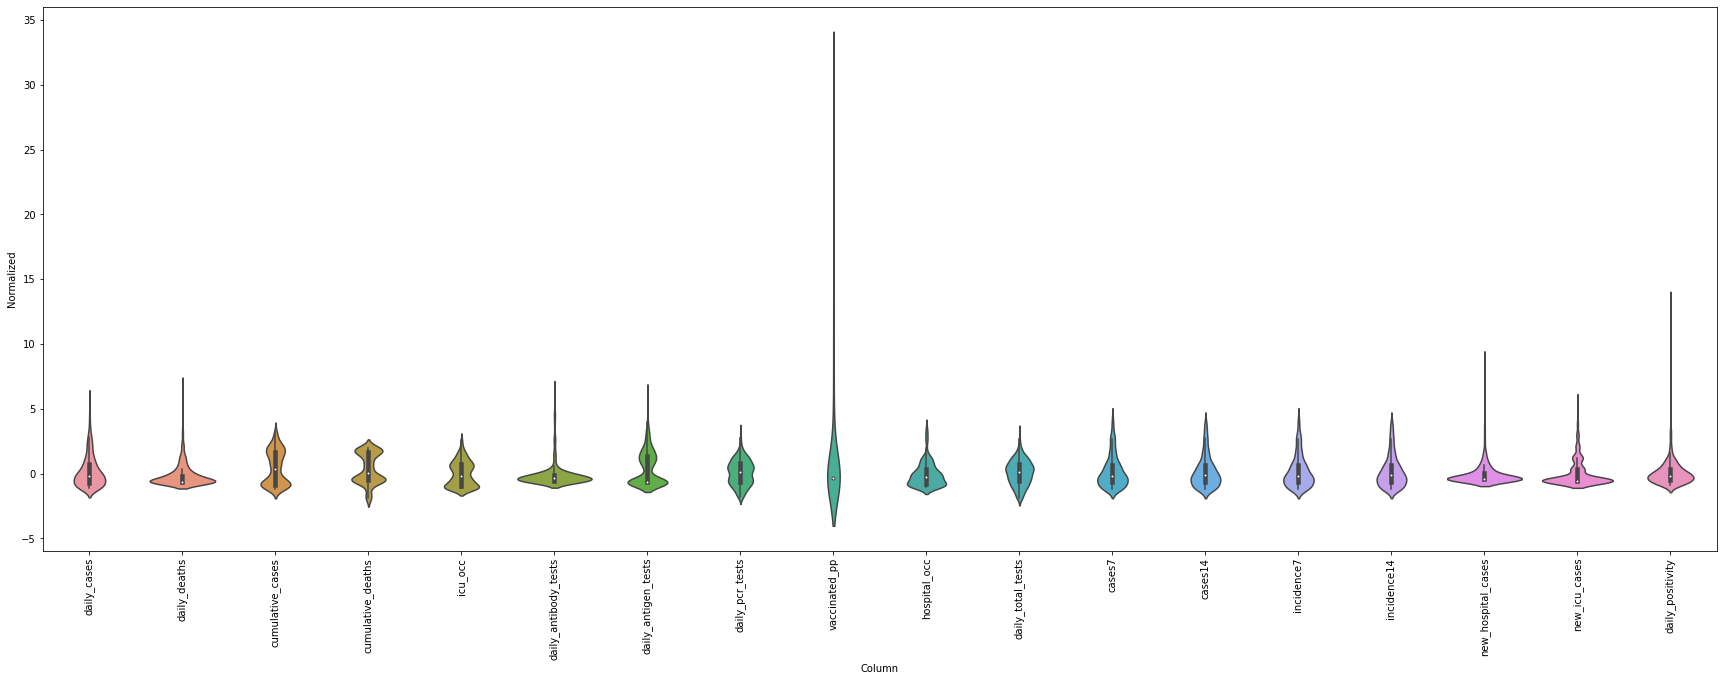

In [10]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(30, 10))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors. The feature `vaccinated_pp` has this form because the start of vaccination was almost one year later.

## Data windowing
Predictions will be based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

The variety of models (including Linear, dense, CNN and RNN models) will be use for:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

### 1. Indexes and offsets
The `WindowGenerator` class handles the indexes and offsets, splits windows of features into `(features, labels)` pairs and converts to `tf.data.Dataset`s the input DataFrames for training, evaluation, and test. The  `__init__` method includes:
* `input_width`: Size of the history window.
* `label_width`: Number of consecutive instants to predict.
* `shift`: Size of the time window from the history window to the last time instant you want to predict.

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [22]:
# Example of one prediction 15 days into the future, given 30 days of history.
w1 = WindowGenerator(input_width=30, label_width=1, shift=15,
                     label_columns=['daily_cases', 'daily_deaths'])
w1

Total window size: 45
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [44]
Label column name(s): ['daily_cases', 'daily_deaths']

### 2. Split
Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  
  return inputs, labels

WindowGenerator.split_window = split_window

In [24]:
# Stack three time slices:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 45, 18)
Inputs shape: (3, 30, 18)
labels shape: (3, 1, 2)


The code above took a batch of three 45-time step windows with 18 features at each time step. It splits them into a batch of 30-time step 18-feature inputs, and a 1-time step 1-feature label.

### 3. Plot

Plot method for split window.

In [25]:
def plot(self, model=None, plot_col=['daily_cases'], max_subplots=3):
    """
    Plot an example of the trained model using the inputs and the labels (target or expected values) obtained
    with split_window() method.
    Args:
        self: Class method.
        model: Model to make predictions.
            If it is None, it not makes predictions, only inputs and labels are plotted.
        plot_col: List of the columns names to predict.
        max_subplots: Maximum number of plots.

    Returns: Graph

    """
    inputs, labels = self.example
    # inputs = self.inputs
    # labels = self.labels

    # index of the column to plot
    plot_col_index = [self.column_indices.get(key) for key in plot_col]
    num_features = len(plot_col_index)
    # plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))  # len(inputs) = n batch
    it = 1
    for n in range(max_n):
        for m in range(num_features):
            plt.subplot(max_n, num_features, it)  # select subplot
            plt.ylabel(f'{plot_col[m]} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index[m]],
                      label='Inputs', marker='.', zorder=-10)
            it += 1

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col[m], None)
            else:
                label_col_index = plot_col_index[m]

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()
            plt.xlabel('Time [days]')
    plt.show()

WindowGenerator.plot = plot

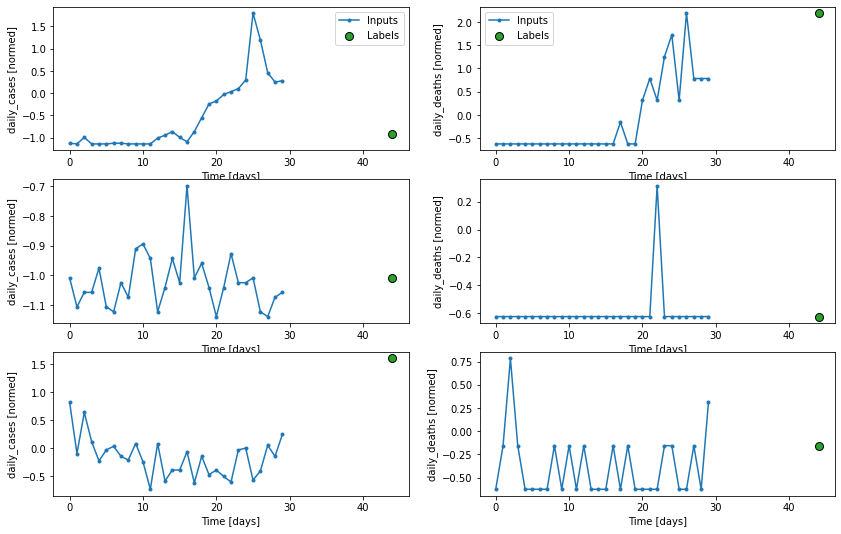

In [26]:
# Example
w1.example = example_inputs, example_labels
w1.plot(plot_col=['daily_cases', 'daily_deaths'])

### 4. Create `tf.data.Dataset`s
The `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs.

In [27]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.


In [28]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [82]:
def compile_and_fit(model, window, patience=3, MAX_EPOCHS=30):
    """
    Compile and fit the models. This function is used with WindowGenerator Object, df.data Datasets and DL models.
    Some ML models need 'x' (features_train) and 'y' (target) to be trained, if you use a Dataset you get an error.
    Args:
        model: Model to fit.
        window: WindowGenerator Object that contains training, validation and test tf.data Dataset
        patience: Argument for early stopping to avoid overfitting.
            Number of epochs to wait before early stop if no progress on the validation set.
        MAX_EPOCHS: Max epochs to train the model.

    Returns:
        History object that provides a clean observation of the performance of deep learning models over
        time during training. Metrics are stored in a dictionary in the history member of the object returned.
        It is useful to plot metrics (accuracy, loss) of Training and Validation Datasets over training time.

    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train,
                        epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history

In [19]:
class WindowGenerator:
    """
    Class to:
    1. Generate a time window.
    2. Split de data into different variables (input and labels) of each tensor. Necessary to plot an example.
    3. Make a dataset from dataframe (train, validation, test).
    4. Plot an example of predictions with the trained model using the inputs and the labels (target or expected values)
        obtained with split_window() method. Predict using the model and inputs and compare with the labels.
    5. Compile and fit the input model and return history object.
    """

    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        """
        Constructs all the necessary attributes for the window.
        Args:
            input_width: Size of the history window. Number of instants used to train the models.
            label_width: Number of consecutive instants to predict.
            shift: Number of instants (lags) between the last lag of history window and the last instant to predict.
            train_df: Train DataFrame
            val_df: Validation DataFrame
            test_df: Test DataFrame
            label_columns: None or a list of the name columns to predict.

        Attributes:
            self.label_columns_indices: Dictionary with the name and its index of the column targets.
            self.column_indices: Dictionary with the name and its index of the dataset.
            self.total_window_size: history window + shift.
            self.input_slice: (0, input_width, None)
            self.input_indices: List from 0 to input_width
            self.labels_slice: (total_window_size - label_width, None, None)
            self.label_indices: List from (total_window_size - label_width) to (total_window_size).
        """

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, data):
        """
        WidowGenerator class method. Split de data into different variables (input and labels) of each tensor.
        Args:
            self: Class method.
            data: List of rank-R tensors.txt.

        Returns:
            inputs: Data of history window used to make the predictions in the plotted example.
            labels: Data with the expected target values of the predictions.
        """
        inputs = data[:, self.input_slice, :]
        labels = data[:, self.labels_slice, :]
        if self.label_columns is not None:
            self.labels = tf.stack(
                [self.labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        # (batch, time, features)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        """
        Make a dataset from input DataFrame (train, validation, test).
        Working with datasets has some advantages when training the model and using fit() arguments.
        (https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)
        Args:
            data: DataFrame.

        Returns: DataSet.

        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.test` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_col=['daily_cases'], max_subplots=3):
        """
        Plot an example of the trained model using the inputs and the labels (target or expected values) obtained
        with split_window() method.
        Args:
            self: Class method.
            model: Model to make predictions.
                If it is None, it not makes predictions, only inputs and labels are plotted.
            plot_col: List of the columns names to predict.
            max_subplots: Maximum number of plots.

        Returns: Graph

        """
        inputs, labels = self.example
        # inputs = self.inputs
        # labels = self.labels

        # index of the column to plot
        plot_col_index = [self.column_indices.get(key) for key in plot_col]
        num_features = len(plot_col_index)
        # plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))  # len(inputs) = n batch
        it = 1
        for n in range(max_n):
            for m in range(num_features):
                plt.subplot(max_n, num_features, it)  # select subplot
                plt.ylabel(f'{plot_col[m]} [normed]')
                plt.plot(self.input_indices, inputs[n, :, plot_col_index[m]],
                         label='Inputs', marker='.', zorder=-10)
                it += 1

                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col[m], None)
                else:
                    label_col_index = plot_col_index[m]

                if label_col_index is None:
                    continue

                plt.scatter(self.label_indices, labels[n, :, label_col_index],
                            edgecolors='k', label='Labels', c='#2ca02c', s=64)
                if model is not None:
                    predictions = model(inputs)
                    plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                                marker='X', edgecolors='k', label='Predictions',
                                c='#ff7f0e', s=64)

                if n == 0:
                    plt.legend()
                plt.xlabel('Time [days]')
        plt.tight_layout(pad=2.0)
        plt.show()


def compile_and_fit(model, window, patience=3, max_epoch=30):
    """
    Compile and fit the models. This function is used with WindowGenerator Object, df.data Datasets and DL models.
    Some ML models need 'x' (features_train) and 'y' (target) to be trained, if you use a Dataset you get an error.
    Args:
        model: Model to fit.
        window: WindowGenerator Object that contains training, validation and test tf.data Dataset
        patience: Argument for early stopping to avoid overfitting.
            Number of epochs to wait before early stop if no progress on the validation set.
        max_epoch: Max epochs to train the model.

    Returns:
        History object that provides a clean observation of the performance of deep learning models over
        time during training. Metrics are stored in a dictionary in the history member of the object returned.
        It is useful to plot metrics (accuracy, loss) of Training and Validation Datasets over training time.

    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train,
                        epochs=max_epoch,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history


## Multi-step models
Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one day into the future. Now these models will make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.

The models will learn to predict 14 days into the future, given 30 days of the past.

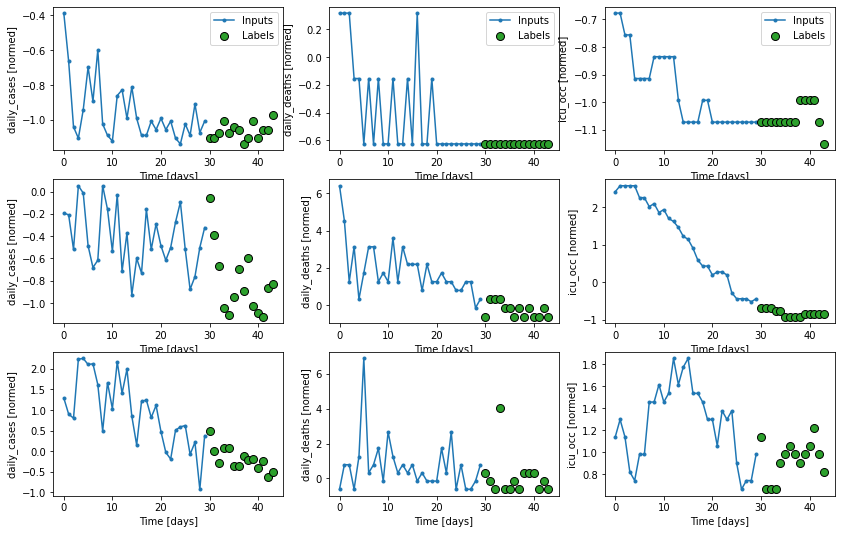

Total window size: 44
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label column name(s): None

In [83]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(plot_col=['daily_cases', 'daily_deaths', 'icu_occ'])
multi_window

#### Baseline
A simple baseline for this task is to repeat the last input time step for the required number of output time steps.

In [84]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_last.png")

2/2 [==============================] - 0s 5ms/step - loss: 5.4553 - mean_absolute_error: 0.7053


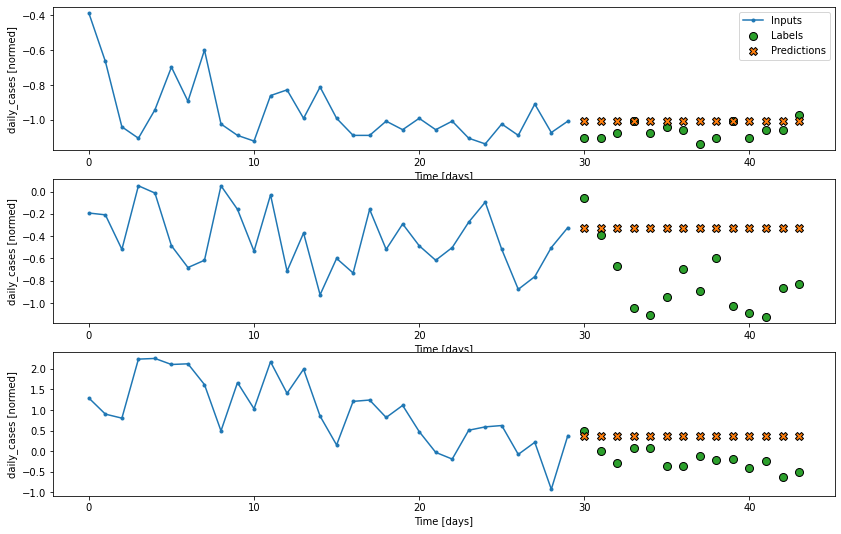

In [85]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Another simple approach is to repeat the previous day, assuming tomorrow will be similar. In this case, the model will learn to predict 14 future days given the same number of past days.

In [86]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_repeat.png")

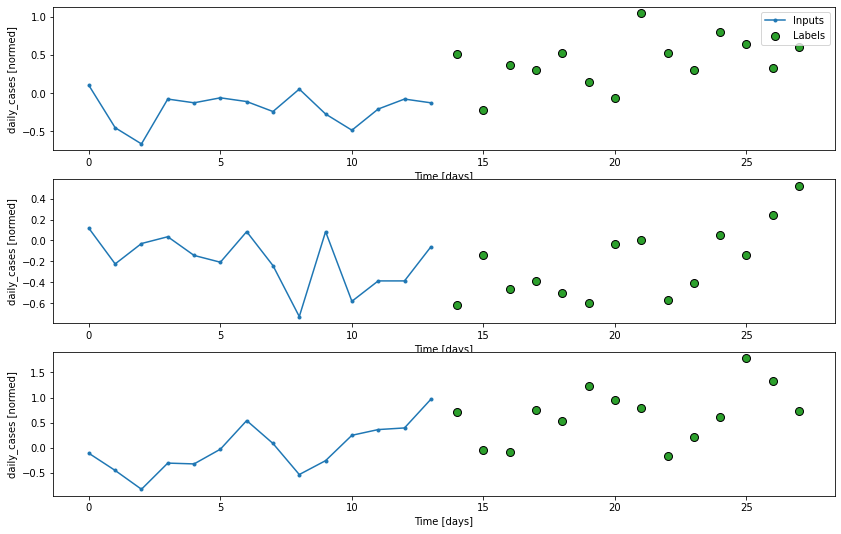

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): None

In [87]:
# 14 future days
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

2/2 [==============================] - 0s 4ms/step - loss: 0.8092 - mean_absolute_error: 0.5079


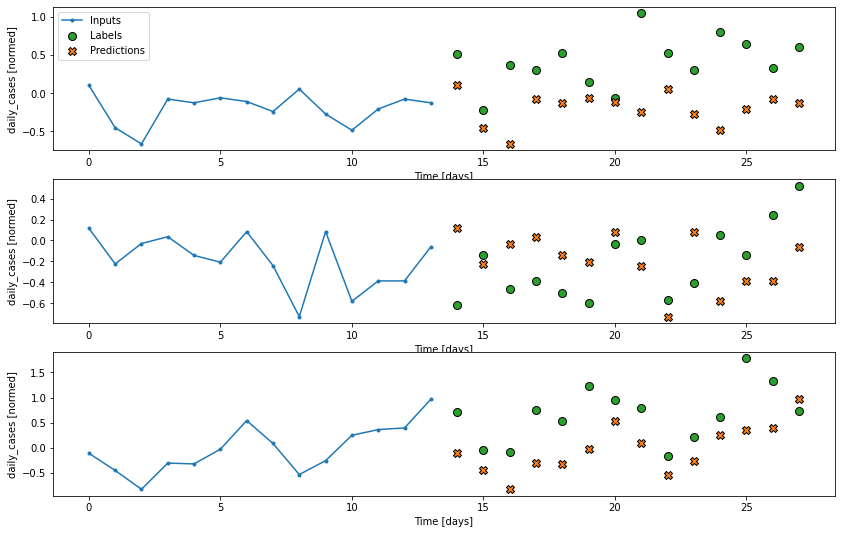

In [88]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

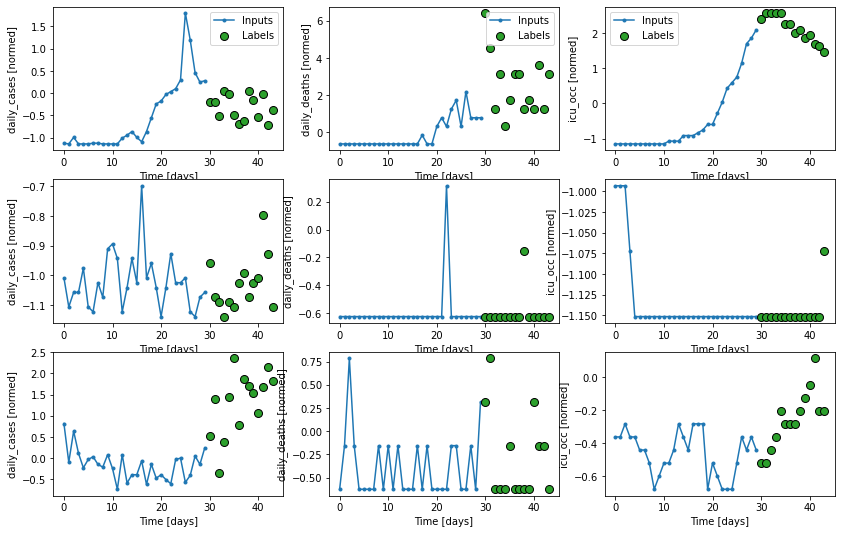

In [89]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df = train_df,
                               val_df = val_df,
                               test_df = test_df)

# Example for some predictions when the model is trained
r1 = random.randint(1, len(train_df) - multi_window.total_window_size)
r2 = random.randint(1, len(train_df) - multi_window.total_window_size)
r3 = random.randint(1, len(train_df) - multi_window.total_window_size)

example_window = tf.stack([np.array(train_df[r1:r1 + multi_window.total_window_size]),
                           np.array(train_df[r2:r2 + multi_window.total_window_size]),
                           np.array(train_df[r3:r3 + multi_window.total_window_size])])
multi_window._example = multi_window.split_window(example_window)
multi_window.plot(plot_col=['daily_cases', 'daily_deaths', 'icu_occ'])

#### Model 1: Linear
A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of month and year.

In [90]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_dense.png")

2/2 [==============================] - 0s 5ms/step - loss: 7.3138 - mean_absolute_error: 1.2461


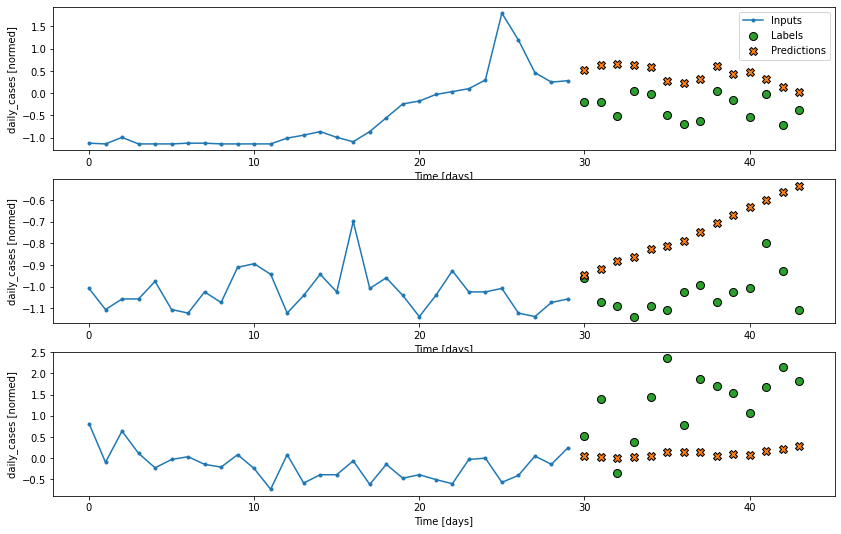

In [91]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


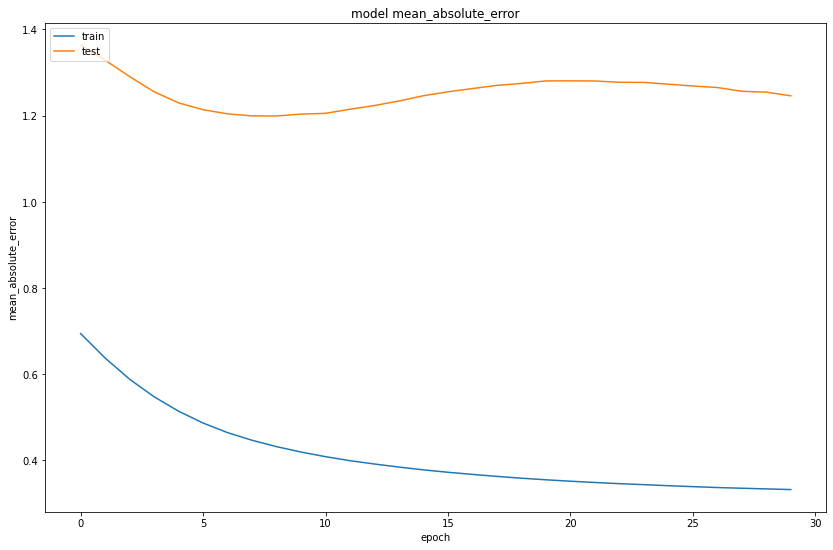

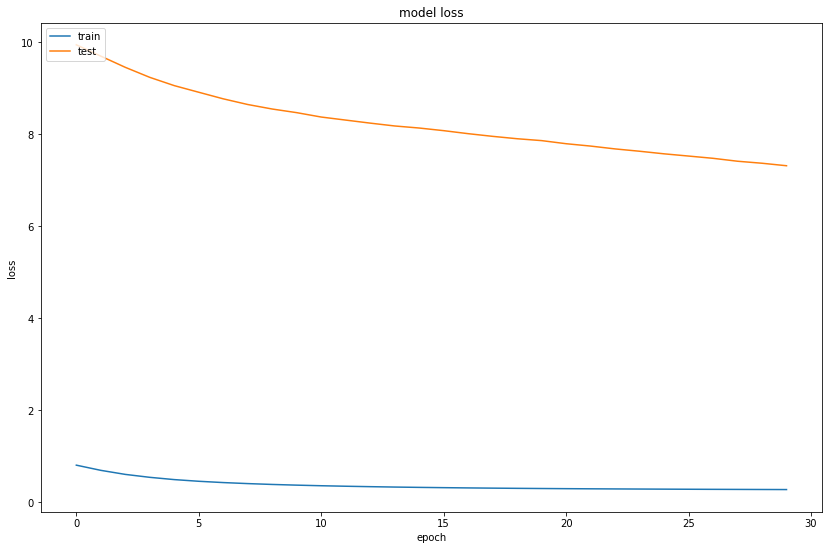

In [92]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 2: Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

2/2 [==============================] - 0s 5ms/step - loss: 5.6562 - mean_absolute_error: 1.0330


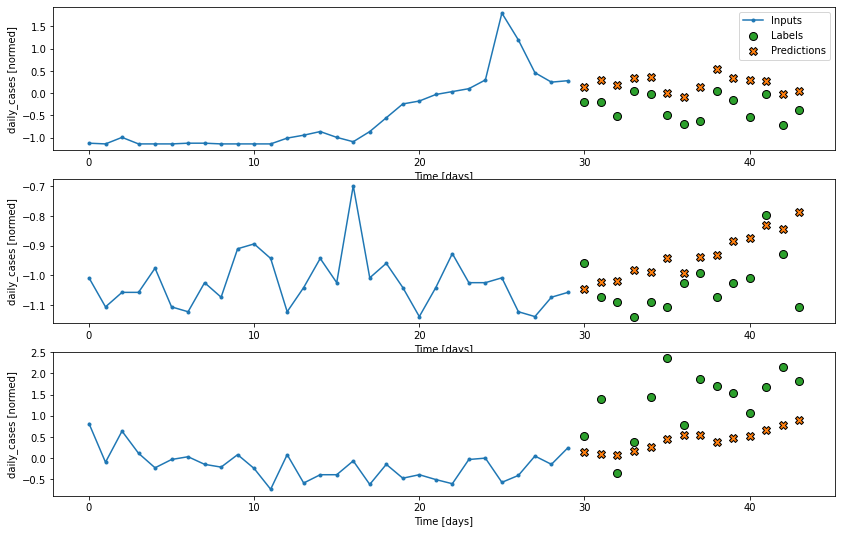

In [93]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


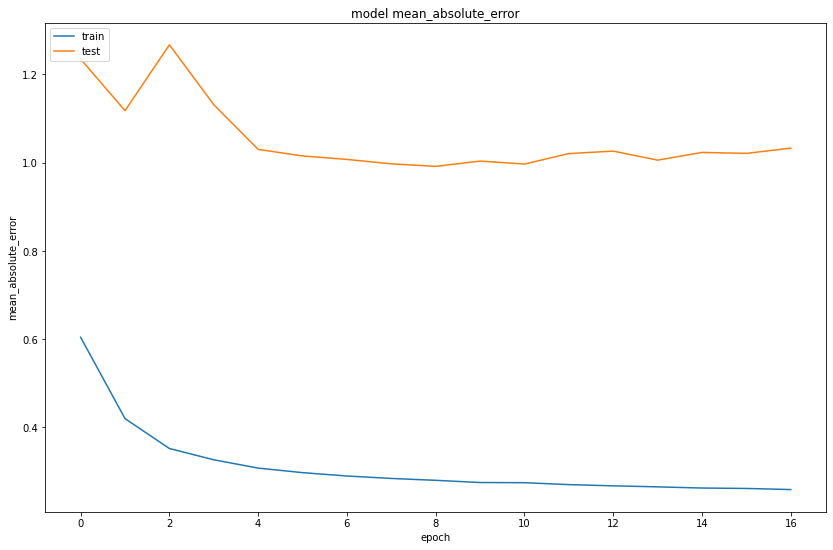

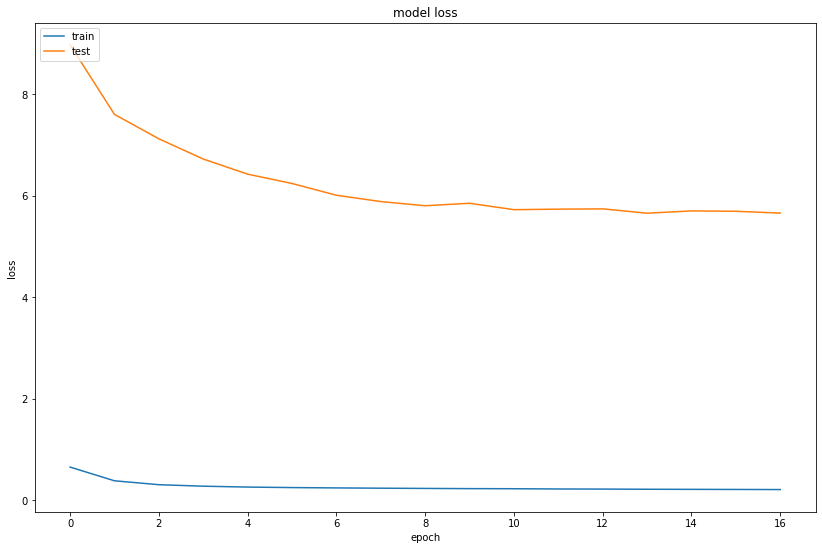

In [94]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 2: Avance: Feed Forward Neural Network

In [95]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# multi_window.plot()
multi_window

Total window size: 54
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
Label column name(s): None

In [96]:
def ffnn(layer_num, layer_cells, out_steps, num_features=18, dropout_rate=0.05):
    """
    Create a custom Feed Forward Neural Network.
    Args:
        layer_num: Number of hidden layers.
        layer_cells: Number of neurones in each hidden layer.
        out_steps: Time instants to be predicted (t_final = t + out_steps).
        num_features: Number of features (columns) to use in the predictions.
        dropout_rate: (0-1). Percentage of randomly selected neurons or units (hidden and visible) that will be ignored
                    during training to prevent NN from overfitting.

    Returns: Feed Forward Neural Network model.

    """

    model = Sequential()
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    model.add(Lambda(lambda x: x[:, -1:, :]))

    for i in range(layer_num):
        model.add(Dense(layer_cells,
                        activation="relu",
                        kernel_initializer="he_uniform",
                        name=f"dense{i}"))
        model.add(Dropout(dropout_rate))

    model.add(Dense(out_steps * num_features,
                    activation="relu"))

    model.add(Dense(out_steps * num_features,
                    kernel_initializer=tf.initializers.zeros()))
    # Shape => [batch, out_steps, features].
    model.add(Reshape([out_steps, num_features]))
    return model

1/1 [==============================] - 0s 54ms/step - loss: 5.3006 - mean_absolute_error: 1.0681


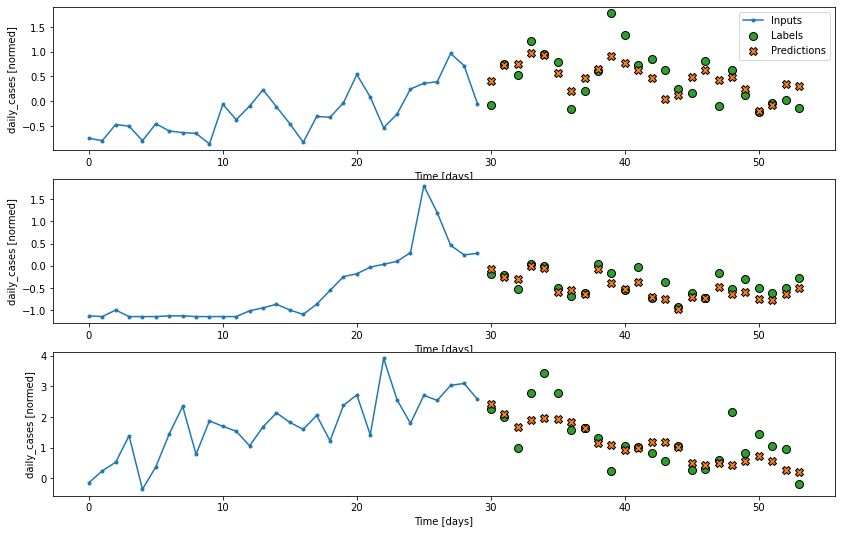

In [97]:
multi_dense_model = ffnn(layer_num=2, layer_cells=500, out_steps=24, dropout_rate=0)

history = compile_and_fit(multi_dense_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


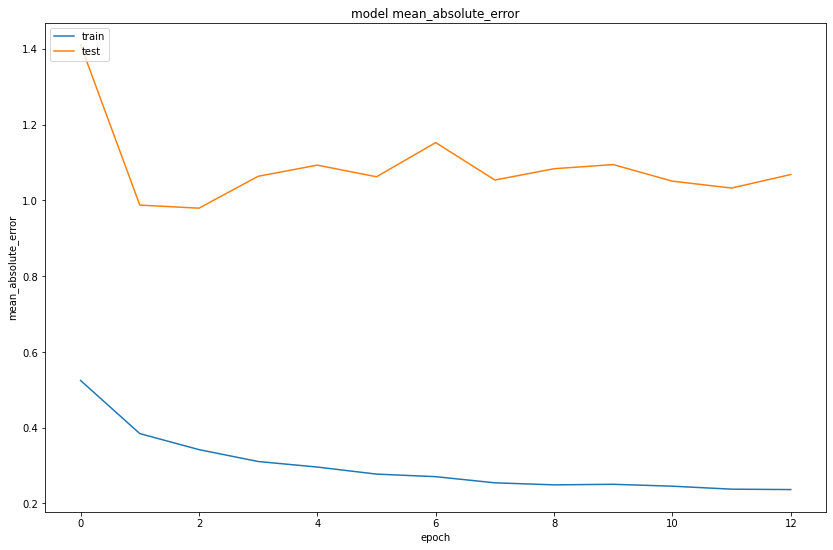

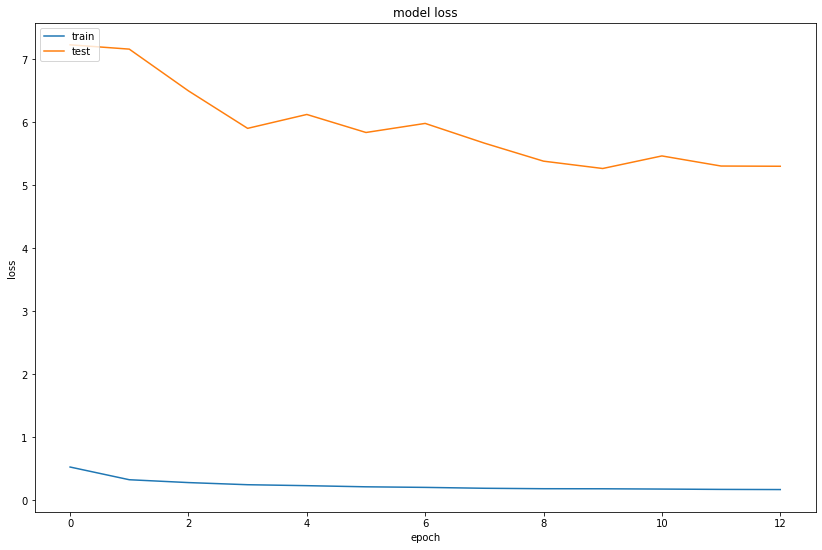

In [98]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### CNN
A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time.

In [99]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_conv.png")

For the CNN, 20 past days (`CONV_WIDTH`) and 30 epochs will be used to predict 14 future days.

2/2 [==============================] - 0s 7ms/step - loss: 2.9680 - mean_absolute_error: 0.8941


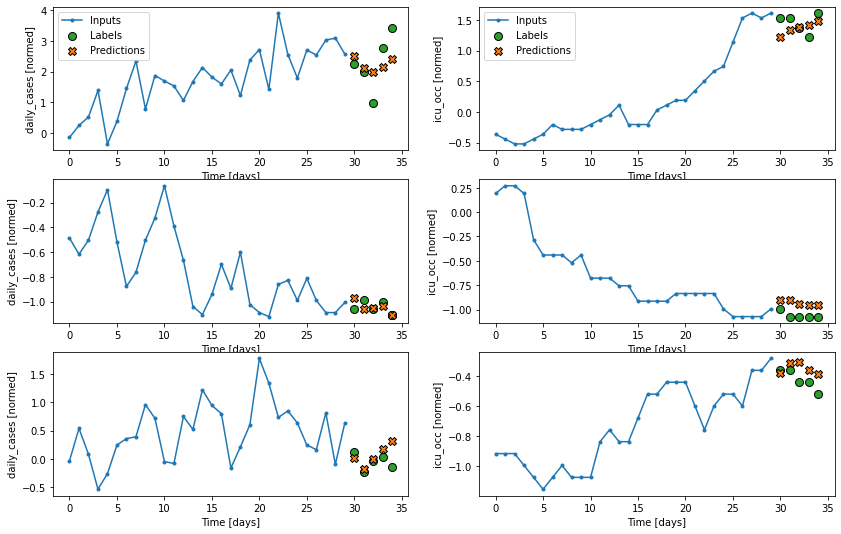

In [100]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

CONV_WIDTH = 20


multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, plot_col=['daily_cases', 'icu_occ'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


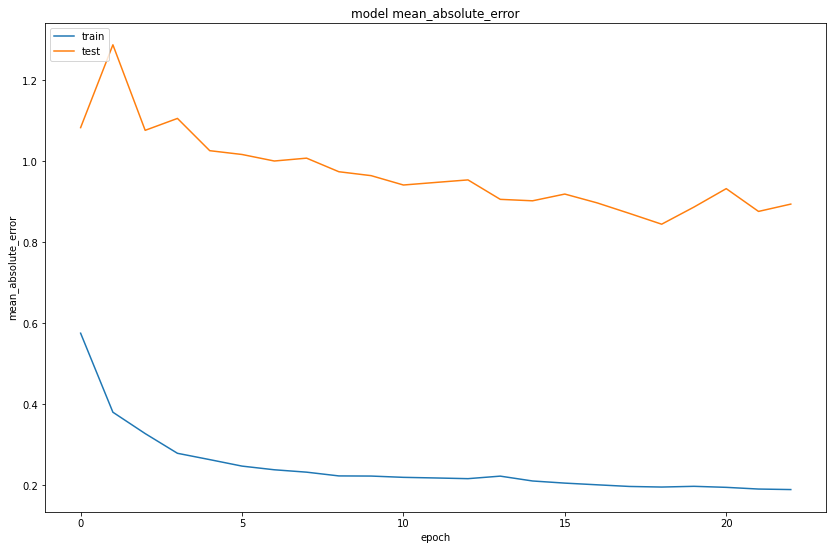

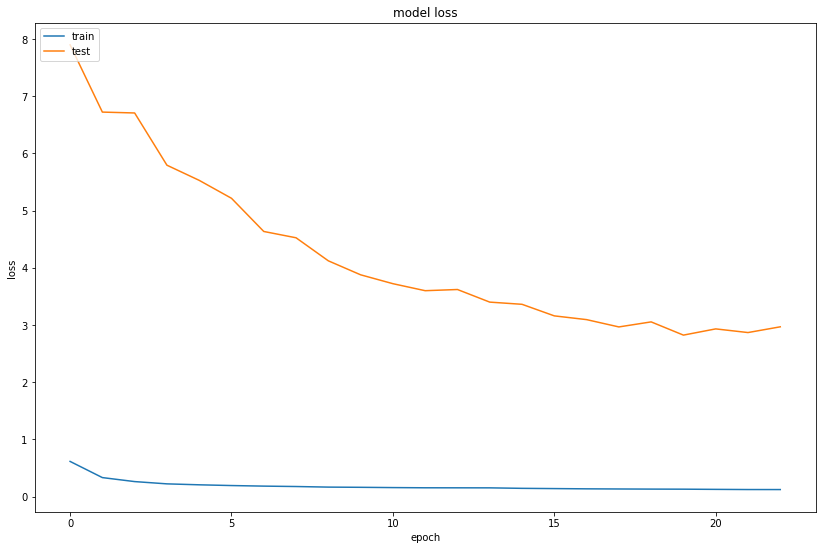

In [101]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### RNN
A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 30 days, before making a single prediction for the next 14 days.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

In [102]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png")

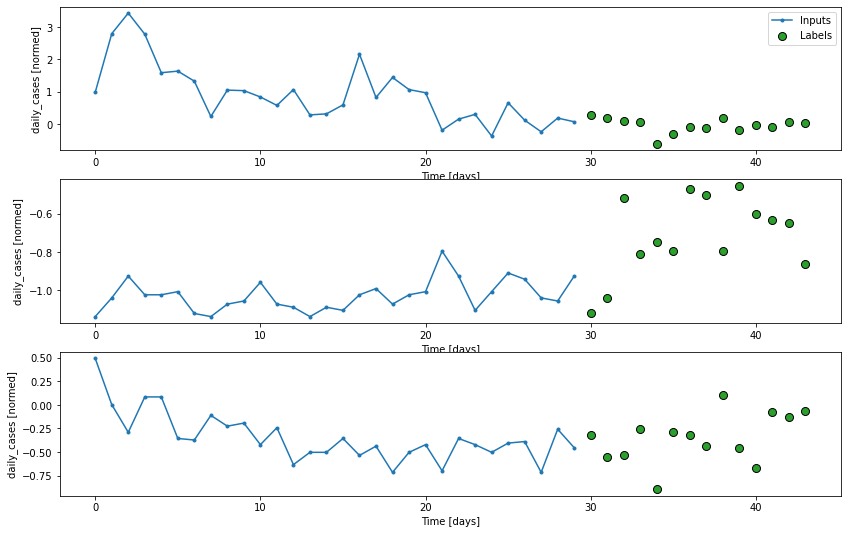

In [103]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()

2/2 [==============================] - 0s 9ms/step - loss: 7.2206 - mean_absolute_error: 1.0583


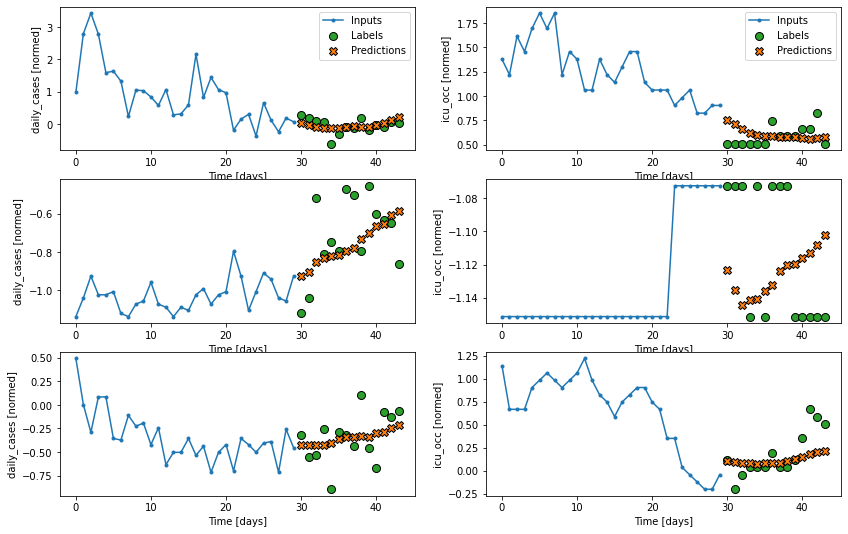

In [104]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(69, return_sequences=False),
    tf.keras.layers.Dropout(0),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(500,
    #                 activation="relu"),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
  #  tf.keras.layers.Dropout(0.05),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col=['daily_cases', 'icu_occ'])

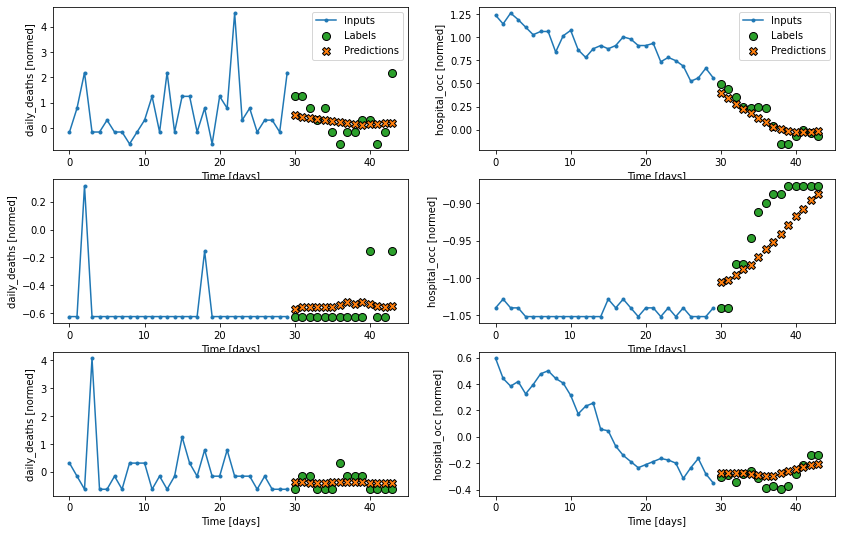

In [105]:
multi_window.plot(multi_lstm_model, plot_col=['daily_deaths', 'hospital_occ'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


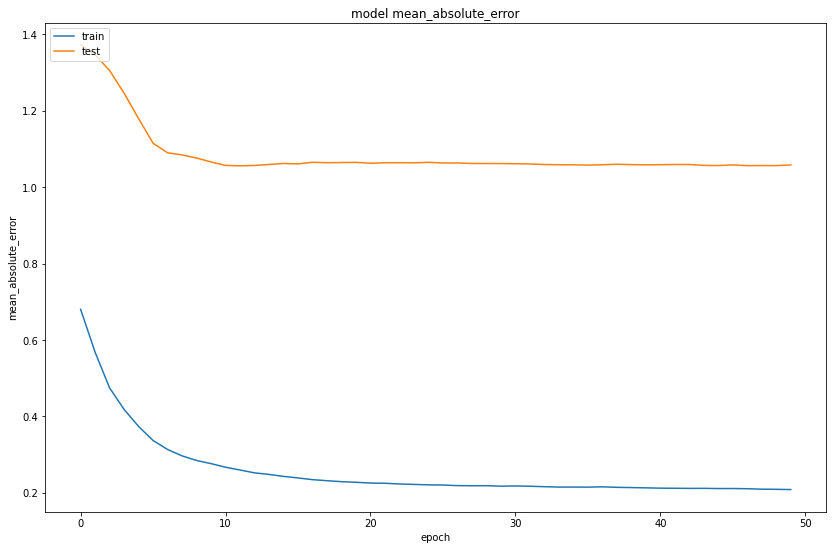

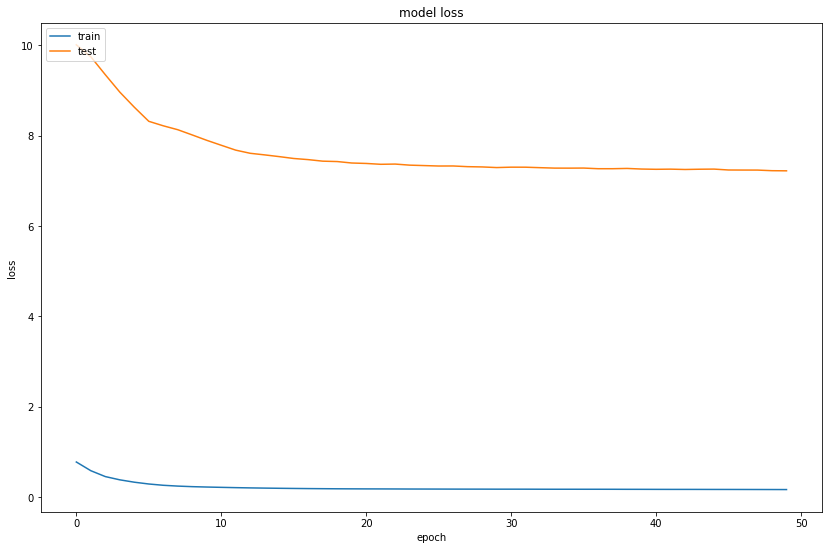

In [106]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Advance: Autoregressive model
The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

In [107]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_autoregressive.png")

##### RNN

Only an autoregressive RNN model will be built, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence result.

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [108]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [109]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier.

In [110]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [111]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 18])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

In [112]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [113]:
print('Input shape (batch, time, features): ',multi_window.example[0].shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


Input shape (batch, time, features):  (32, 30, 18)
Output shape (batch, time, features):  (32, 14, 18)


Now, train the model.

2/2 [==============================] - 0s 9ms/step - loss: 8.3216 - mean_absolute_error: 1.1229


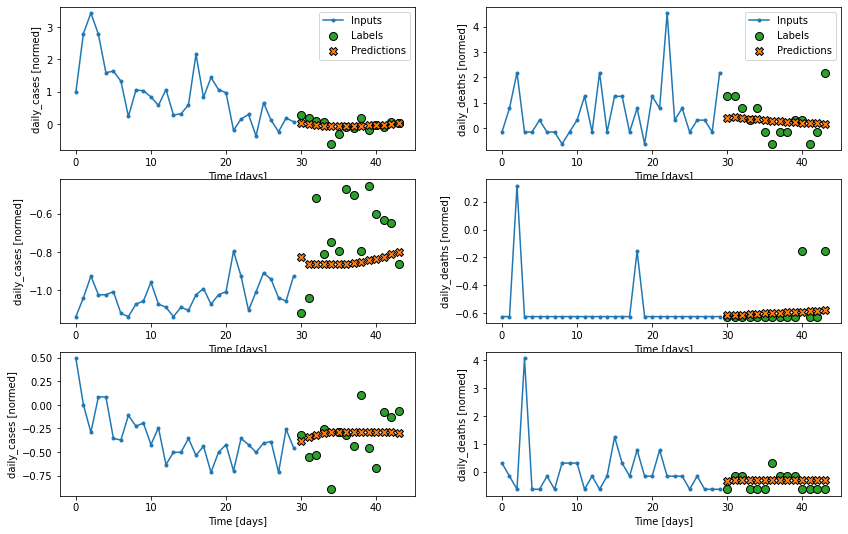

In [114]:
history = compile_and_fit(feedback_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model, plot_col=['daily_cases', 'daily_deaths'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


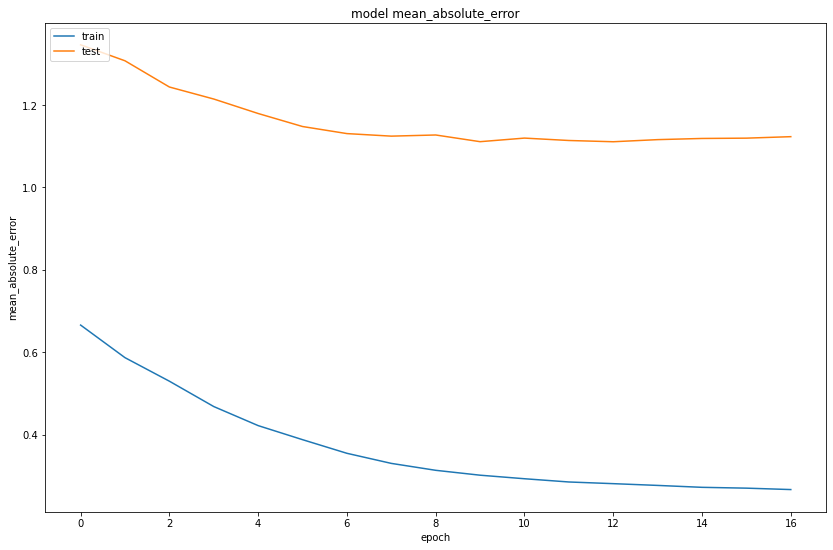

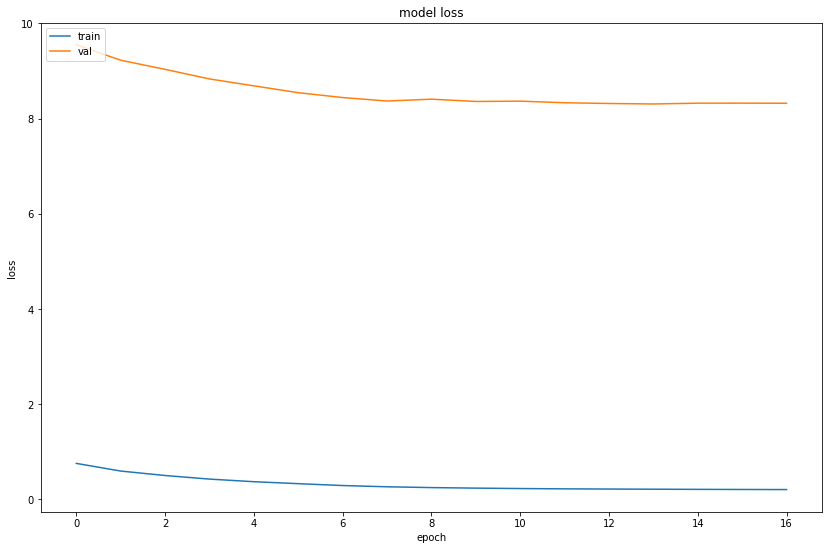

In [115]:
# list all data in history
print((history.history.keys()))
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Performance

In [118]:
multi_val_df = pd.DataFrame.from_dict(data=multi_val_performance,
                                      orient='index',
                                      columns=['Loss', 'MAE'])
print("Validation MAE: \n", multi_val_df)
# print(multi_performance)

Validation MAE: 
              Loss       MAE
Last     5.455253  0.705287
Repeat   0.809242  0.507853
Linear   7.313841  1.246134
Dense    5.300558  1.068113
Conv     2.968038  0.894087
LSTM     7.220600  1.058312
AR LSTM  8.321562  1.122888


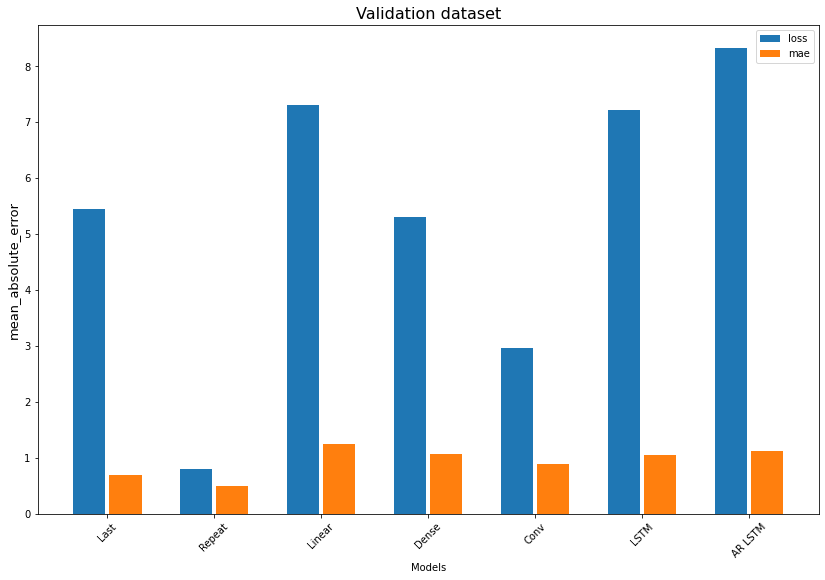

In [120]:
x = np.arange(len(multi_val_df))
width = 0.3
metric_name = 'mean_absolute_error'
plt.ylabel(f'{metric_name}', fontsize=13)
plt.xlabel('Models')
plt.title('Validation dataset', fontsize=16)

loss_metric = multi_val_df['Loss'].values
mae_metric = multi_val_df['MAE'].values
plt.bar(x - 0.17, loss_metric, width, label='loss')
plt.bar(x + 0.17, mae_metric, width, label='mae')
plt.xticks(ticks=x,
           labels=multi_val_performance.keys(),
           rotation=45)
_ = plt.legend()

These more complex approaches may not be worth while on this problem, but there was no way to know without trying.